In this notebook data from merged .csv (vibration and temperature) are loaded and processed by 'utils.data_utils' functions. In the end all the processed data is saved in binary format and visualized

In [1]:
import itertools
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

from bokeh.plotting import figure
from bokeh.io import show
from bokeh.palettes import Dark2_5 as palette
from bokeh.layouts import row, column


from utils import data_model

from utils.visualization   import scatter3d_plot

from utils.preprocessing_c import derivative

from utils.preprocessing   import ( cumsum, hankel_svdvals, correlation_coeffs,
                                    fft_spectrogram, step_change_point, rms,
                                    imfs_decomposition )


%matplotlib notebook 
%load_ext autoreload
%autoreload 2

In [2]:
dataset_path = 'data/processed_data/femto_dataset'

# 'all' or a list of bearings name (e.g. 'all' or ['Bearing1_1', 'Bearing2_5', 'Bearing3_1', ...])
bearings_to_load = ['Bearing1_1', 'Bearing2_5', 'Bearing3_1']

# 'all' or a list of data names (e.g. 'all' or ['acc', 'temp', 'cumsum', 'fft_spectogram', ...])
# results from 'data_utils' functions have the same data name of its corresponding function 
data_to_load = 'all'

bearings = data_model.load(dataset_path, bearings_to_load, data_to_load)

---

Defining kwargs for preprocessing functions

In [6]:
fs = 25600                                 # 25600 Hz
recording_time = 0.1                       # 0.1 seconds
pts_per_recording = int(fs*recording_time) # 2560 points per recording


hankel_svdvals_kw = {'hankel_window_size' : 9,
                     'slice_window_size' : pts_per_recording}


correlation_coeffs_kw = {'baseline' : 0,
                         'norm_interval' : [-1, 1],
                         'filter_window_size' : 3,
                         'filter_polyorder' : 2}


fft_spectrogram_kw = {'slice_window_size' : pts_per_recording, 
                      'recording_time' : recording_time,
                      'fs' : fs}

# Some problems here in derivative because the time difference between some data points is not '1/fs' = 39.06 us
# because the time difference between the last datapoint of a recording and the first datapoint of the next
# recording is 10s
derivative_kw = {'h' : 1/fs}


rms_kw = {'slice_window_size' : pts_per_recording}


imfs_decomp_kw = {'slice_window_size' : pts_per_recording}

In [ ]:
for bearing in bearings:
    
    ### Vibration data
    acc_v = bearing.data['acc']['v']
    
    
    ### Preprocessing functions 
    bearing.data['cumsum_v'] = cumsum(acc_v)
    
    
    bearing.data['hankel_svdvals_v'] = hankel_svdvals(acc_v, **hankel_svdvals_kw)
        
    
    bearing.data['correlation_coeffs_v'] = correlation_coeffs(bearing.data['hankel_svdvals_v'],
                                                              **correlation_coeffs_kw)
    
    ## Some data analysis functions bellow. Not needed for regression
    
    #bearing.data['fft_spectrogram_v'] = fft_spectrogram(acc_v, **fft_spectrogram_kw)
    
    
    #bearing.data['derivative_v'] = np.asarray(derivative(acc_v.to_numpy(), **derivative_kw))
    
    
    #bearing.data['rms_v'] = rms(acc_v, **rms_kw)
    
    
    #bearing.data['imfs_decomposition_v'] = imfs_decomposition(acc_v, **imfs_decomp_kw)
    
        
    #bearing.data['deriv_step_change_point_v'] = step_change_point(bearing.data['derivative_v'])
    
    
    #bearing.data['cumsum_step_change_point_v'] = step_change_point(bearing.data['cumsum_v'])
    
    
    ### Saving processed data
    bearing.save_data()

---

# Processed Data Visualization

## Cummulative Sum

In [ ]:
step = 200
s_cumsum = []

for bearing in bearings:
    
    data = bearing.data['cumsum_v'][::step]
    
    figure_kw = {
        'plot_width'  : 500, 
        'plot_height' : 500, 
        'title' : 'Cummulative Sum.',
        'x_axis_label' : 'Recordings',
        'y_axis_label' : 'Cummulative Sum'
    }
    
    plot_kw = {
        'x' : np.arange(len(data)),
        'y' : data,
        "legend_label" : '%s' % (bearing.name)
    }
    
    s = figure(**figure_kw)
    s.line(**plot_kw)
    s.legend.location = 'bottom_left'
    
    s_cumsum.append(s)

show(row(column(s_cumsum)))

## Correlation Coefficients

In [ ]:
s_svd = []
for bearing in bearings:
    
    data = bearing.data['correlation_coeffs_v']
    
    figure_kw = {
        'plot_width'  : 500, 
        'plot_height' : 500, 
        'title' : 'Hankel matrix singular values correlation coefficients.',
        'x_axis_label' : 'Recordings',
        'y_axis_label' : 'Correlation coefficients'
    }
    
    plot_kw = {
        'x' : np.arange(len(data)),
        'y' : data,
        "legend_label" : '%s' % (bearing.name)
    }
    
    s = figure(**figure_kw)
    s.circle(**plot_kw)
    s.legend.location = 'bottom_left'
    
    s_svd.append(s)

show(row(column(s_svd)))

## FFT Spectogram 3D

In [ ]:
step = 8
x, y, z = bearings[0].data['fft_spectrogram_v']

fft_spectogram_kw = {
    'filename' : 'fft_spectrogram_3d.html',
    'x' : np.hstack(x)[::step], 
    'y' : np.hstack(y)[::step], 
    'z' : np.hstack(z)[::step]
}


scatter3d_plot(**fft_spectogram_kw)

## RMS

In [ ]:
s_rms = []

for bearing in bearings:
    
    data = bearing.data['rms_v']
    
    figure_kw = {
        'plot_width'  : 500, 
        'plot_height' : 500, 
        'title' : 'RMS.',
        'x_axis_label' : 'Recordings',
        'y_axis_label' : 'RMS'
    }
    
    plot_kw = {
        'x' : np.arange(len(data)),
        'y' : data,
        "legend_label" : '%s' % (bearing.name)
    }
    
    s = figure(**figure_kw)
    s.line(**plot_kw)
    s.legend.location = 'bottom_left'
    
    s_rms.append(s)

show(row(column(s_rms)))

## IMFS Decomposition

In [4]:
data = bearings[0].data['imfs_decomposition_v']
imf_num = 3

imf = [x[imf_num] for x in data]

<IPython.core.display.Javascript object>


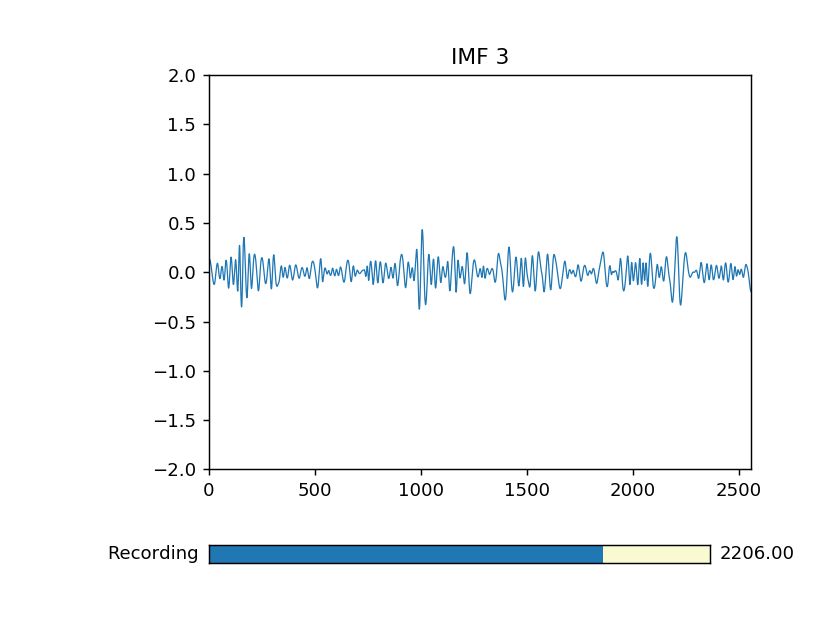

In [5]:
# Update data with slider
def update(val):
    data = imf[int(s_recording.val)]
    l.set_ydata(data)
    fig.canvas.draw_idle()

fig, ax = plt.subplots()
# Configure the limit if data is not appearing
ax.set_ylim(-2, 2)
plt.subplots_adjust(left=0.25, bottom=0.25)
plt.title("IMF %s" % imf_num)

# Plotting the first recording result
l, = plt.plot(np.arange(2560), imf[0], lw=0.7)
ax.margins(x=0)

axcolor = 'lightgoldenrodyellow'
ax_recording = plt.axes([0.25, 0.1, 0.6, 0.03], facecolor=axcolor)

s_recording = Slider(ax_recording, 'Recording', 0, len(imf), valinit=0, valstep=1)
s_recording.on_changed(update)

plt.show()